In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import numpy as np
from pandas import Series
import seaborn as sns
from matplotlib.pyplot import figure
import cmocean.cm as cmo
import seaborn as sns

from pylab import rcParams
from numpy import diff
from scipy import interpolate
import scipy.stats as stats

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from scipy.signal import savgol_filter

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import matplotlib.gridspec as gridspec
from IPython.display import display, Math

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
#get ctd files 
files = glob.glob('../Dissertation_projects/Data/CTD/DOWNCAST_RENAME/*.csv') 

files

['../Dissertation_projects/Data/CTD/DOWNCAST_RENAME\\CTD_GOM2021_St.11_2128_07-25-21.csv',
 '../Dissertation_projects/Data/CTD/DOWNCAST_RENAME\\CTD_GOM2021_St.13_2124_07-21-21_1.csv',
 '../Dissertation_projects/Data/CTD/DOWNCAST_RENAME\\CTD_GOM2021_St.14_2122_07-19-21.csv',
 '../Dissertation_projects/Data/CTD/DOWNCAST_RENAME\\CTD_GOM2021_St.15_2126_07-23-21.csv',
 '../Dissertation_projects/Data/CTD/DOWNCAST_RENAME\\CTD_GOM2021_St.16_2127_07-24-21.csv',
 '../Dissertation_projects/Data/CTD/DOWNCAST_RENAME\\CTD_GOM2021_St.2_2125_07-22-21.csv',
 '../Dissertation_projects/Data/CTD/DOWNCAST_RENAME\\CTD_GOM2021_St.4_2121_07-17-21.csv',
 '../Dissertation_projects/Data/CTD/DOWNCAST_RENAME\\CTD_GOM2021_St.5B_2120_07-16-21.csv',
 '../Dissertation_projects/Data/CTD/DOWNCAST_RENAME\\CTD_GOM2021_St.7_2129_07-26-21_1.csv',
 '../Dissertation_projects/Data/CTD/DOWNCAST_RENAME\\CTD_GOM2021_St.9_2123_07-20-21.csv',
 '../Dissertation_projects/Data/CTD/DOWNCAST_RENAME\\CTD_GOM2021_St.MK_2119_07-15-21.csv',

In [3]:
#make vars 
stations = ['St.11', 'St.12', 'St.13', 'St.14-2', 'St.14', 'St.16-2',
            'St.16', 'St.2', 'St.4', 'St.6', 'St.7',
            'St.9', 'St.MK-2', 'St.MK', 'St.15', 'St.5B']
camps = ['GOM2021','GOM21FA', 'GOM22SP', 'GOM22SU']

select = camps[0] #0 to 2
selectstn = stations[0] #0 to 15

#pick out the vars you need
df1 = pd.read_csv(files[0])
cols_to_select = df1.columns.tolist()

#make the data frame 

frames = []

for f in files: 
    df = pd.read_csv(f)
    
    ID = f.split("\\")[1]
    ID = ID[:-4].split("_")
    
    camp = ID[1]
    station = ID[2]
    sample_id = ID[3]
    date = ID[4]
    
    maxd = df['Pressure [dbar]'].max()
    lat = df['latitude'].mean()
    lon = df['longitude'].mean()
    
    df_new = df.loc[:, cols_to_select]
    
    df_new['camp'] = camp
    df_new['station'] = station
    df_new['sample_id'] = sample_id
    df_new['date'] = date
    df_new['maxd'] = maxd
    df_new['lat'] = lat
    df_new['lon'] = lon
    
    frames.append(df_new)
    
ds = pd.concat(frames, axis=0)

ds_copy = ds['wetCDOM'].copy()
ds_copy.loc[ds_copy < -1] = np.nan
ds_copy.loc[ds_copy > 125] = np.nan
ds = pd.merge(ds, ds_copy, left_index=True, right_index=True, how='outer')
ds = ds.rename(columns={'wetCDOM_x': 'wetCDOM', 'wetCDOM_y': 'wetCDOM_clean'})

ds['date_time'] = pd.to_datetime(ds['date'])
ds['dates'] = ds['date_time'].dt.date

# get the unique values for each group
station_vals = ds['station'].unique()
camp_vals = ds['camp'].unique()

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_15280\2879452403.py:53: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ds['date_time'] = pd.to_datetime(ds['date'])


In [4]:
df_meta = pd.read_csv('../Dissertation_projects/Data/meta_data.csv', sep=',', index_col=0)

#fix date time 
df_meta['date_time'] = pd.to_datetime(df_meta['Date'])
df_meta['Date'] = df_meta['date_time'].dt.date

df_meta['code'] = df_meta['Station'] + '_' + df_meta['Trip']


# Group by 'code' and calculate the mean while ignoring NaN values
grouped_df = df_meta.groupby('code')[['Lat', 'Lon']].mean(numeric_only=True)

# Reset the index to make it a table
grouped_df.reset_index(inplace=True)
grouped_df.index = grouped_df['code']
df_met = grouped_df.drop('code', axis = 1)

In [5]:
#Stats 
ds_ctd = ds
print(ds_ctd.columns)
ds_ctd = ds_ctd.reset_index(drop=True)

# Group by 'camp' and 'station' and extract the min and max 'Pressure [dbar]'
grouped = ds_ctd.groupby(['camp', 'station'])

# Functions to get the values associated with min and max pressures
def get_val_at_min_pressure(group, column):
    idx = group['Pressure [dbar]'].idxmin()
    return group.loc[idx, column]

def get_val_at_max_pressure(group, column):
    idx = group['Pressure [dbar]'].idxmax()
    return group.loc[idx, column]

# Aggregate data based on min and max pressures
summary = grouped.agg(
    dates=('dates', 'first'),
    maxd=('maxd', 'first'),
    Pressure_dbar_surface=('Pressure [dbar]', 'min'),
    O2_mgL_surface=('sbeox0Mg/L', lambda x: get_val_at_min_pressure(ds_ctd.loc[x.index], 'sbeox0Mg/L')),
    latitude_surface=('latitude', lambda x: get_val_at_min_pressure(ds_ctd.loc[x.index], 'latitude')),
    longitude_surface=('longitude', lambda x: get_val_at_min_pressure(ds_ctd.loc[x.index], 'longitude')),
    Pressure_dbar_bottom=('Pressure [dbar]', 'max'),
    O2_mgL_bottom=('sbeox0Mg/L', lambda x: get_val_at_max_pressure(ds_ctd.loc[x.index], 'sbeox0Mg/L')),
    latitude_bottom=('latitude', lambda x: get_val_at_max_pressure(ds_ctd.loc[x.index], 'latitude')),
    longitude_bottom=('longitude', lambda x: get_val_at_max_pressure(ds_ctd.loc[x.index], 'longitude')), 
    
    temp_surface=('t068C', lambda x: get_val_at_min_pressure(ds_ctd.loc[x.index], 't068C')),
    temp_bottom=('t068C', lambda x: get_val_at_max_pressure(ds_ctd.loc[x.index], 't068C')), 
    
    sal_surface=('sal00', lambda x: get_val_at_min_pressure(ds_ctd.loc[x.index], 'sal00')),
    sal_bottom=('sal00', lambda x: get_val_at_max_pressure(ds_ctd.loc[x.index], 'sal00'))
)

# Rename columns
summary = summary.rename(columns={'camp': 'campaign', 'maxd': 'Max_pressure', 'dates': 'date'})

# Reset index
O2_summary = summary.reset_index()
O2_summary['O2_uM_surface'] = O2_summary['O2_mgL_surface']/1000/31.999*1000000
O2_summary['O2_uM_bottom'] = O2_summary['O2_mgL_bottom']/1000/31.999*1000000
O2_summary['temp_surface'] = O2_summary['temp_surface']
O2_summary['temp_bottom'] = O2_summary['temp_bottom']

O2_summary

Index(['Pressure [dbar]', 'nbf', 'c0S/m', 'density00', 'wetCDOM', 'flECO-AFL',
       'latitude', 'longitude', 'sbeox0Mg/L', 'par', 'sal00', 't090C', 't068C',
       'timeM', 'turbWETbb0', 'flag', 'camp', 'station', 'sample_id', 'date',
       'maxd', 'lat', 'lon', 'wetCDOM_clean', 'date_time', 'dates'],
      dtype='object')


,camp,station,date,Max_pressure,Pressure_dbar_surface,O2_mgL_surface,latitude_surface,longitude_surface,Pressure_dbar_bottom,O2_mgL_bottom,latitude_bottom,longitude_bottom,temp_surface,temp_bottom,sal_surface,sal_bottom,O2_uM_surface,O2_uM_bottom
0,GOM2021,St.11,2021-07-25,946.986,2.076,7.3366,28.21678,-89.54664,946.986,7.8471,28.22178,-89.54278,29.9854,5.1025,36.1896,34.9346,229.275915,245.229538
1,GOM2021,St.13,2021-07-21,321.519,2.283,6.2980,28.53696,-89.49614,321.519,5.5889,28.53642,-89.49372,29.8063,11.2036,35.0741,35.3737,196.818651,174.658583
2,GOM2021,St.14,2021-07-19,91.278,1.829,6.3473,28.72514,-89.60390,91.278,4.9078,28.72566,-89.60308,30.2016,19.1043,31.1088,36.4047,198.359324,153.373543
3,GOM2021,St.15,2021-07-23,287.295,2.191,9.0433,28.94254,-88.83508,287.295,5.4067,28.94148,-88.83200,29.4733,11.3417,29.3293,35.3946,282.611957,168.964655
4,GOM2021,St.16,2021-07-24,61.804,1.277,7.4623,28.88042,-89.54684,61.804,5.2200,28.87900,-89.54708,29.8499,20.7100,20.4683,36.3277,233.204163,163.130098
5,GOM2021,St.2,2021-07-22,63.413,2.074,6.8821,28.89964,-89.59322,63.413,4.7733,28.89960,-89.59318,28.9431,20.7587,27.5856,36.3022,215.072346,149.170287
6,GOM2021,St.4,2021-07-17,17.437,1.145,8.2318,28.79886,-90.71040,17.437,2.9017,28.79930,-90.71148,30.3120,27.7279,24.8396,35.3894,257.251789,90.680959
7,GOM2021,St.5B,2021-07-16,12.856,1.505,7.6929,28.81030,-91.34152,12.856,7.1658,28.81072,-91.34212,29.8254,28.7477,29.1495,33.7462,240.410638,223.938248
8,GOM2021,St.7,2021-07-26,39.529,1.736,9.3420,28.91830,-89.87558,39.529,3.9643,28.91828,-89.87558,30.1656,24.3561,25.4665,36.0396,291.946623,123.888247
9,GOM2021,St.9,2021-07-20,79.028,2.283,7.0499,28.79980,-89.59940,79.028,5.4915,28.79978,-89.59864,28.8984,19.8699,33.4888,36.3728,220.316260,171.614738


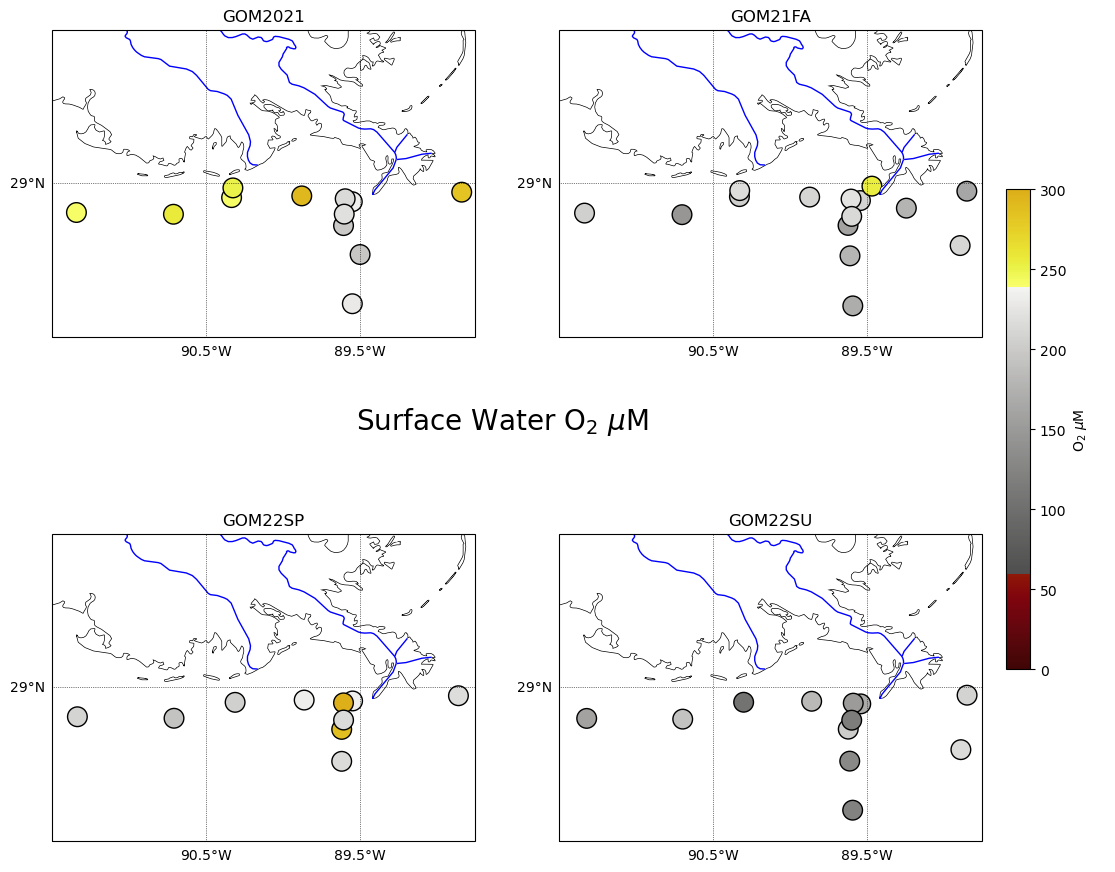

In [6]:
lat_top=30
lat_bot=28
lon_left=-91.5
lon_rigth=-88.75
extent=[lon_left, lon_rigth, lat_bot, lat_top]

# List of unique Camp values you want to plot
camps = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

#set params 
vmin = 0
vmax = 300
plot_save = "../Dissertation_projects/Figures/CTD_profiles/O2_maps/Surface.png"
cb_name = r'O$_2$ $\mu$M'+'\n'

def plot_mapbase(extent, ax=None, res='10m', projection=ccrs.PlateCarree()):
    if ax is None:
        fig = plt.figure(figsize=(10,5)) # set fig size
        ax = fig.add_subplot(111, projection=projection)
        
    ax.set_extent(extent)
    ax.coastlines(res)
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='land',
                                                facecolor='white', 
                                                scale=res)) 
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='rivers_lake_centerlines',
                                                edgecolor='blue',
                                                facecolor='none',
                                                scale=res))
    gl = ax.gridlines(xlocs=np.arange(lon_left, lon_rigth+1),
                      ylocs=np.arange(lat_bot, lat_top+1),
                      draw_labels=True, 
                      linewidth=0.5, color='k', linestyle=':')
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return ax

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.ravel()  # Flatten the 2x2 grid to access each subplot with a single index
for i, camp in enumerate(camps):
    df_subset = O2_summary[O2_summary['camp'] == camp]  
    
    # Plot the base map for each subplot
    plot_mapbase(extent, ax=axes[i])
    
    # Plotting
    mappable = axes[i].scatter(df_subset['longitude_surface'], df_subset['latitude_surface'],
                               c=df_subset['O2_uM_surface'],
                               edgecolor='k',
                               cmap=cmo.oxy,
                               s=200,
                               vmin=vmin,  
                               vmax=vmax,
                               transform=ccrs.PlateCarree())
    
    # Set title for each subplot
    axes[i].set_title(camp)
    
# Add a single colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
cb = fig.colorbar(mappable, cax=cbar_ax)
cb.set_label(cb_name, size=10, color='black')
cb.ax.tick_params(labelcolor='black') 
cb.ax.tick_params(labelsize=10)

fig.text(0.5, 0.5, r'Surface Water O$_2$ $\mu$M', size=20, ha='center')

fig.set_facecolor('w')
plt.savefig(plot_save)
plt.show()

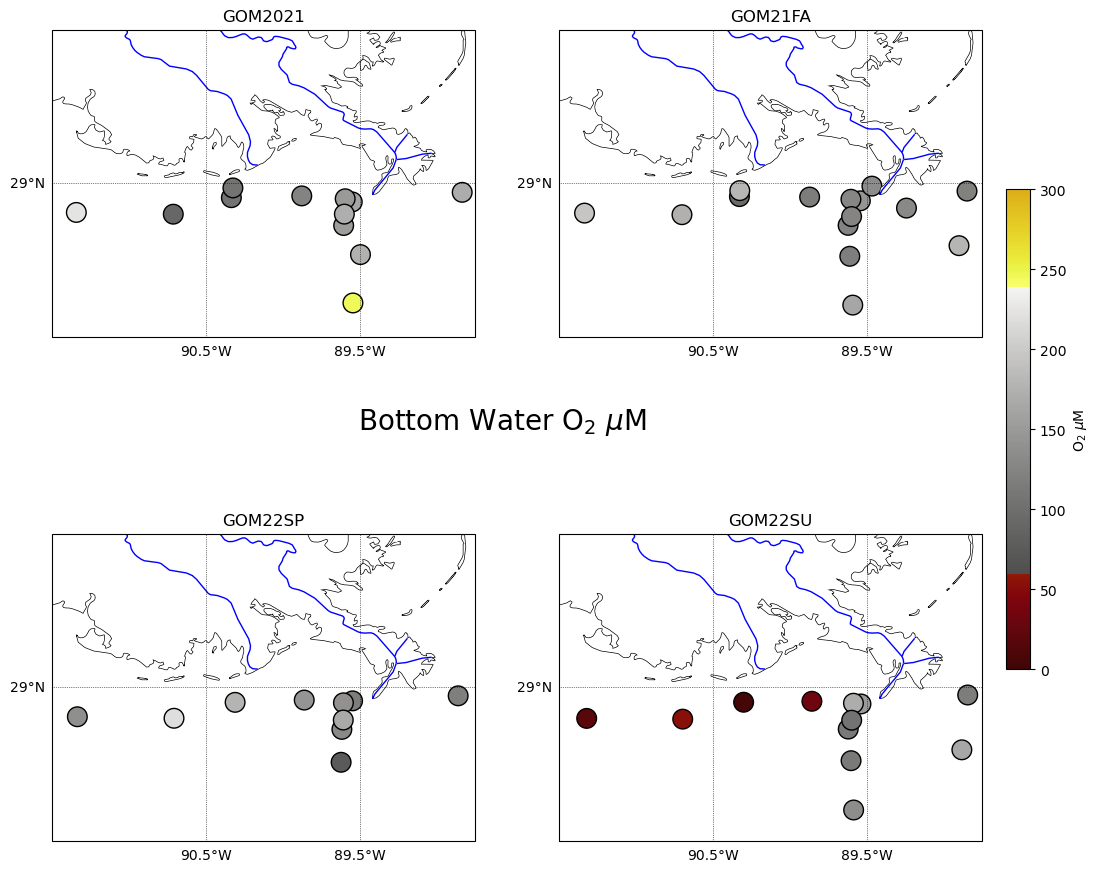

In [7]:
lat_top=30
lat_bot=28
lon_left=-91.5
lon_rigth=-88.75
extent=[lon_left, lon_rigth, lat_bot, lat_top]

# List of unique Camp values you want to plot
camps = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

#set params 
vmin = 0
vmax = 300
plot_save = "../Dissertation_projects/Figures/CTD_profiles/O2_maps/Bottom.png"
cb_name = r'O$_2$ $\mu$M'+'\n'

def plot_mapbase(extent, ax=None, res='10m', projection=ccrs.PlateCarree()):
    if ax is None:
        fig = plt.figure(figsize=(10,5)) # set fig size
        ax = fig.add_subplot(111, projection=projection)
        
    ax.set_extent(extent)
    ax.coastlines(res)
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='land',
                                                facecolor='white', 
                                                scale=res)) 
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='rivers_lake_centerlines',
                                                edgecolor='blue',
                                                facecolor='none',
                                                scale=res))
    gl = ax.gridlines(xlocs=np.arange(lon_left, lon_rigth+1),
                      ylocs=np.arange(lat_bot, lat_top+1),
                      draw_labels=True, 
                      linewidth=0.5, color='k', linestyle=':')
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return ax

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.ravel()  # Flatten the 2x2 grid to access each subplot with a single index
for i, camp in enumerate(camps):
    df_subset = O2_summary[O2_summary['camp'] == camp]  
    
    # Plot the base map for each subplot
    plot_mapbase(extent, ax=axes[i])
    
    # Plotting
    mappable = axes[i].scatter(df_subset['longitude_bottom'], df_subset['latitude_bottom'],
                               c=df_subset['O2_uM_bottom'],
                               edgecolor='k',
                               cmap=cmo.oxy,
                               s=200,
                               vmin=vmin,  
                               vmax=vmax,
                               transform=ccrs.PlateCarree())
    
    # Set title for each subplot
    axes[i].set_title(camp)
    
# Add a single colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
cb = fig.colorbar(mappable, cax=cbar_ax)
cb.set_label(cb_name, size=10, color='black')
cb.ax.tick_params(labelcolor='black') 
cb.ax.tick_params(labelsize=10)

fig.text(0.5, 0.5, r'Bottom Water O$_2$ $\mu$M', size=20, ha='center')

fig.set_facecolor('w')
plt.savefig(plot_save)
plt.show()

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_15280\2263122225.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(categories)


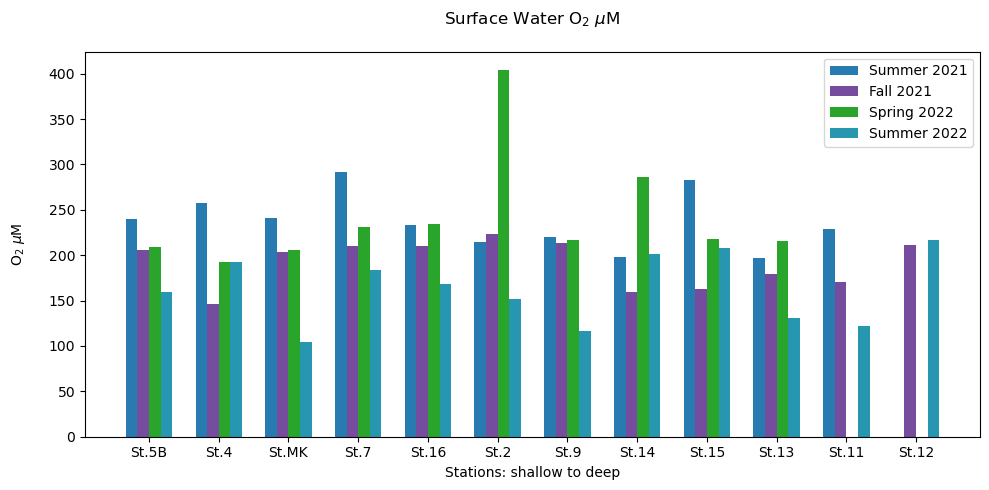

In [8]:
# Unique categories and subcategories
categories = ['St.5B','St.4','St.MK','St.7','St.16','St.2','St.9','St.14','St.15','St.13','St.11','St.12']
subcategories = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

# Define custom colors
color_map = {
    'GOM2021': '#277BB1',
    'GOM21FA': '#754C9E',
    'GOM22SP': '#2AA52C',
    'GOM22SU': '#2796B1'
}

# Define custom labels (if they differ from subcategory names)
label_map = {
    'GOM2021': 'Summer 2021',
    'GOM21FA': 'Fall 2021',
    'GOM22SP': 'Spring 2022',
    'GOM22SU': 'Summer 2022'
}

barWidth = 0.25

def bar_plot(data_f):
    # Create figure with custom size
    fig = plt.figure(figsize=(10, 5))

    # Adjusted r for spacing between groups
    r = np.arange(0, len(categories) * 1.5, 1.5)
    positions = [r + i*barWidth for i in range(len(subcategories))]

    # Adjusted code for bars
    for pos, subcat in zip(positions, subcategories):
        values = []
        for cat in categories:
            value = data_f[(data_f['station'] == cat) & (data_f['camp'] == subcat)][topic].values
            values.append(value[0] if len(value) > 0 else 0)
        
        ax = plt.subplot(1, 1, 1)
        ax.bar(pos, [v if v > 0 else 0 for v in values], width=barWidth, color=color_map[subcat], label=label_map[subcat])

    # Assuming you have a maximum value for y-axis in data_f[topic]
    max_value = data_f[topic].max()*1.05
    ax.set_ylim(0, max_value)  

    # Additional layout modifications
    ax.set_xlabel('Stations: shallow to deep')
    ax.set_ylabel(r'O$_2$ $\mu$M'+'\n')
    ax.set_title(title)
    #ax.set_xticks([r + barWidth for r in range(len(categories))])
    ax.set_xticklabels(categories)
    ax.set_xticks(r + 1.5*barWidth) 

    handles, _ = plt.gca().get_legend_handles_labels()
    labels = [label_map[subcat] for subcat in subcategories]
    ax.legend(handles[:len(subcategories)], labels)

    fig.set_facecolor('w')
    plt.tight_layout()

    plt.savefig(plot_save)
    plt.show()

topic = "O2_uM_surface"
plot_save = "../Dissertation_projects/Figures/CTD_profiles/O2_maps/Bar_top.png"
title = r'Surface Water O$_2$ $\mu$M'+'\n'

bar_plot(O2_summary)

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_15280\2263122225.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(categories)


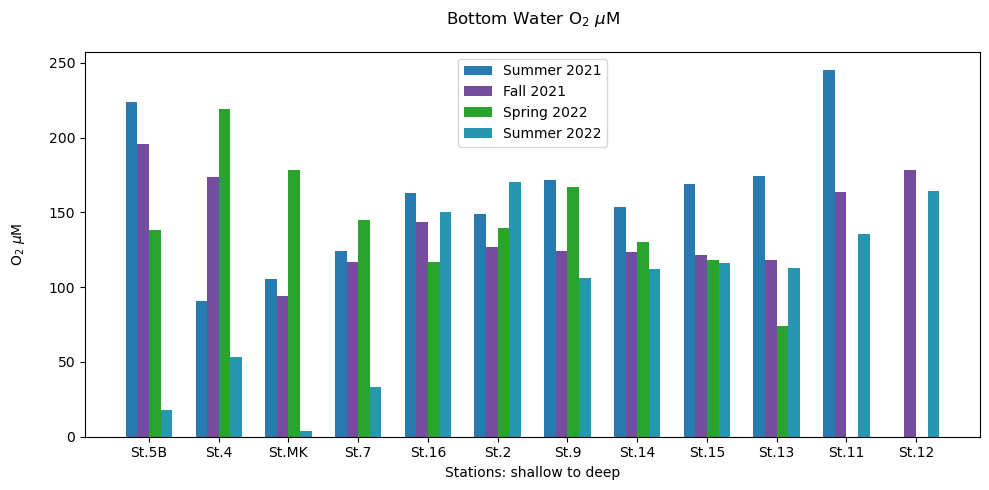

In [9]:
topic = "O2_uM_bottom"
plot_save = "../Dissertation_projects/Figures/CTD_profiles/O2_maps/Bar_bot.png"
title = r'Bottom Water O$_2$ $\mu$M'+'\n'

bar_plot(O2_summary)

# Reset index of ds_ctd
ds_ctd = ds_ctd.reset_index(drop=True)

# Group by 'camp' and 'station'
grouped = ds_ctd.groupby(['camp', 'station'])

# Loop through each group to create plots
for (camp, station), group in grouped:
    plt.figure(figsize=(3, 6))
    
    # Plot the data
    plt.plot(group['sbeox0Mg/L'], group['Pressure [dbar]'], color='black', linewidth=2)
    
    # Set axis limits and labels
    plt.xlim(0, ds_ctd['sbeox0Mg/L'].max())
    plt.ylim(group['maxd'].max(), 0)  # inverting y-axis as pressure increases downwards
    plt.xlabel('O2 (mg/L)', size = 15)
    plt.ylabel('Pressure [dbar]', size = 15)
    plt.title(station + "\n" + pd.to_datetime(group['dates'].iloc[0]).strftime('%B %d, %Y'), size = 16)
    
    # Update tick parameters
    plt.gca().tick_params(axis='both', colors='black', labelsize=15)
    
    # Save the figure
    plt.tight_layout()
    plt.savefig('../Dissertation_projects/Figures/CTD_profiles/O2_profiles/' + f"{camp}_{station}_O2_profile.png")
    
    # Show the figure
    plt.show()


# Reset index of ds_ctd
ds_ctd = ds_ctd.reset_index(drop=True)

# Group by 'camp' and 'station'
grouped = ds_ctd.groupby(['camp', 'station'])

# Number of unique groups
n_groups = len(grouped)

# Calculate the grid dimensions
n_cols = 10
n_rows = -(-n_groups // n_cols)  # Ceiling division

# Create a grid of subplots without sharing x and y
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*1.25, n_rows*3))
fig.suptitle('O2 Profiles', fontsize=20)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Flattening the axes for easy indexing
if axes.ndim > 1:
    axes = axes.ravel()

# Iterate through the groups and plot data on respective subplots
for idx, ((camp, station), group) in enumerate(grouped):
    ax = axes[idx]
    
    # Plot data
    ax.plot(group['sbeox0Mg/L'], group['Pressure [dbar]'], color='black', linewidth=2)
    
    # Set individual x and y limits for each subplot
    ax.set_xlim(0, ds_ctd['sbeox0Mg/L'].max())
    ax.set_ylim(group['Pressure [dbar]'].max(), 0)  # inverted y-axis
    
    # Set title for the subplot
    ax.set_title(station + "\n" + pd.to_datetime(group['dates'].iloc[0]).strftime('%B %d, %Y'), fontsize=8)
    
    # Update tick parameters
    ax.tick_params(axis='both', colors='black', labelsize=10)

    # Set x and y labels for subplots on the edges of the grid
    if idx // n_cols == n_rows - 1:  # bottom-most plots
        ax.set_xlabel('O2 (mg/L)', fontsize=10)
    if idx % n_cols == 0:  # left-most plots
        ax.set_ylabel('Pressure [dbar]', fontsize=10)

# Save the figure
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to account for the title
plt.savefig('../Dissertation_projects/Figures/CTD_profiles/O2_profiles/O2_profiles_grid.png')

# Show the figure
plt.show()


# Reset index of ds_ctd
ds_ctd = ds_ctd.reset_index(drop=True)

# Group by 'camp' and 'station'
grouped = ds_ctd.groupby(['camp', 'station'])

# Number of unique groups
n_groups = len(grouped)

# Calculate the grid dimensions
n_cols = 10
n_rows = -(-n_groups // n_cols)  # Ceiling division

# Create a grid of subplots without sharing x and y
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*1.25, n_rows*3))
fig.suptitle('O2 Profiles: scales adjusted', fontsize=20)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Flattening the axes for easy indexing
if axes.ndim > 1:
    axes = axes.ravel()

# Iterate through the groups and plot data on respective subplots
for idx, ((camp, station), group) in enumerate(grouped):
    ax = axes[idx]
    
    # Plot data
    ax.plot(group['sbeox0Mg/L'], group['Pressure [dbar]'], color='black', linewidth=2)
    
    # Set individual x and y limits for each subplot
    ax.set_xlim(group['sbeox0Mg/L'].min(), group['sbeox0Mg/L'].max())
    ax.set_ylim(group['Pressure [dbar]'].max(), 0)  # inverted y-axis
    
    # Set title for the subplot
    ax.set_title(station + "\n" + pd.to_datetime(group['dates'].iloc[0]).strftime('%B %d, %Y'), fontsize=8)
    
    # Update tick parameters
    ax.tick_params(axis='both', colors='black', labelsize=10)

    # Set x and y labels for subplots on the edges of the grid
    if idx // n_cols == n_rows - 1:  # bottom-most plots
        ax.set_xlabel('O2 (mg/L)', fontsize=10)
    if idx % n_cols == 0:  # left-most plots
        ax.set_ylabel('Pressure [dbar]', fontsize=10)

# Save the figure
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to account for the title
plt.savefig('../Dissertation_projects/Figures/CTD_profiles/O2_profiles/O2_profiles_grid_scaled.png')

# Show the figure
plt.show()


# Reset index of ds_ctd
ds_ctd = ds_ctd.reset_index(drop=True)

# Group by 'camp' and 'station'
grouped = ds_ctd.groupby(['camp', 'station'])

# Number of unique groups
n_groups = len(grouped)

# Calculate the grid dimensions
n_cols = 10
n_rows = -(-n_groups // n_cols)  # Ceiling division

# Create a grid of subplots without sharing x and y
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*1.25, n_rows*3))
fig.suptitle('O2 Profiles: scales adjusted', fontsize=20)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Flattening the axes for easy indexing
if axes.ndim > 1:
    axes = axes.ravel()

# Moving average function
def moving_average(data, window_size=5):
    """Calculate moving average with specified window size."""
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

# Iterate through the groups and plot data on respective subplots
for idx, ((camp, station), group) in enumerate(grouped):
    ax = axes[idx]
    
    window = round(len(group['sbeox0Mg/L'])/50)
    
    # Plot original data
    #ax.plot(group['sbeox0Mg/L'], group['Pressure [dbar]'], color='black', linewidth=2)

    # Calculate smoothed data and plot
    smoothed_data = moving_average(group['sbeox0Mg/L'].values, window)
    ax.plot(smoothed_data, group['Pressure [dbar]'].values[window-1:], color='green', linewidth=2)  # Note the slicing to align the data after smoothing
    
    # Set individual x and y limits for each subplot
    ax.set_xlim(group['sbeox0Mg/L'].min(), group['sbeox0Mg/L'].max())
    ax.set_ylim(group['Pressure [dbar]'].max(), 0)  # inverted y-axis
    
    # Set title for the subplot
    ax.set_title(station + "\n" + pd.to_datetime(group['dates'].iloc[0]).strftime('%B %d, %Y'), fontsize=8)
    
    # Update tick parameters
    ax.tick_params(axis='both', colors='black', labelsize=10)

    # Set x and y labels for subplots on the edges of the grid
    if idx // n_cols == n_rows - 1:  # bottom-most plots
        ax.set_xlabel('O2 (mg/L)', fontsize=10)
    if idx % n_cols == 0:  # left-most plots
        ax.set_ylabel('Pressure [dbar]', fontsize=10)

# Save the figure
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to account for the title
plt.savefig('../Dissertation_projects/Figures/CTD_profiles/O2_profiles/O2_profiles_smoothed.png')

# Show the figure
plt.show()


Station:  St.MK
Date:  2022-07-23
Slope:  -40.19660134144886
Intercept:  678.401291070971
Pressure:  12.324


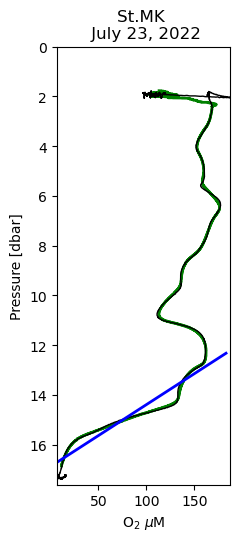

In [10]:
#set up code system 
ds_ctd['code'] = ds_ctd['station'] + '_' + ds_ctd['camp']
ds_ctd['O2_uM'] = ds_ctd['sbeox0Mg/L']/1000/31.999*1000000

cast_n = ds_ctd['code'].unique()
cast_n

#Set up summary system 
O2_summary['code'] = O2_summary['station'] + '_' + O2_summary['camp']
O2_summary.index = O2_summary['code']
O2_summary['Slope'] = np.nan
O2_summary['Slope_pressure'] = np.nan

# Savitzky-Golay filter function Definition 
def savgol_smoothing(data, window_size=5, poly_order=2):
    """Apply Savitzky-Golay filter for data smoothing."""
    return savgol_filter(data, window_size, poly_order)

#for each ctd cast 
x = 49
winsplit = 20
cut_percent = .4

def Slope_plot(x,winsplit,cut_percent):
    ds = ds_ctd[ds_ctd['code'].isin([cast_n[x]])]
    ds2 = ds
    
    # Create a single subplot
    fig, ax = plt.subplots(figsize=(2.5, 6))
    ds = ds.sort_values(by=['Pressure [dbar]'])
    ds = ds[:-(round(len(ds)*cut_percent))]

    window = round(len(ds)/winsplit)
    if window % 2 == 0:  # window size must be odd for savgol_filter
        window += 1

    # Smooth the data
    smoothed_data = savgol_smoothing(ds['O2_uM'].values, window)
    smoothed_depths = ds['Pressure [dbar]'].values
    ax.plot(smoothed_data, smoothed_depths, color='green', linewidth=2)

    # Calculate differences
    differences = np.diff(smoothed_data)
    switch_idx = None
    for i in range(len(differences)-1, 0, -1):
        if differences[i] * differences[i-1] < 0:
            switch_idx = i
            break

    # Plot regression 
    if switch_idx is not None:
        slope, intercept, _, _, _ = linregress(smoothed_depths[switch_idx:], smoothed_data[switch_idx:])
        ax.plot(ds2['O2_uM'], ds2['Pressure [dbar]'], color='black',linewidth = 1)
        ax.plot(smoothed_depths[switch_idx:] * slope + intercept, smoothed_depths[switch_idx:], color='blue', linewidth=2)

    print("Station: ", ds['station'].iloc[0])
    print("Date: ", ds['dates'].iloc[0])
    print("Slope: ", slope)
    print("Intercept: ", intercept)
    print("Pressure: ", ds['Pressure [dbar]'].iloc[switch_idx])
    
    # Update O2_summary dataframe
    O2_summary.loc[cast_n[x], 'Slope'] = slope
    O2_summary.loc[cast_n[x], 'Slope_pressure'] = ds['Pressure [dbar]'].iloc[switch_idx]

    # Set plot attributes
    ax.set_xlim(ds['O2_uM'].min()-5, ds['O2_uM'].max())
    ax.set_ylim(ds2['Pressure [dbar]'].max(), 0)  # inverted y-axis
    ax.set_title(f"{ds['station'].iloc[0]} \n {pd.to_datetime(ds['dates'].iloc[0]).strftime('%B %d, %Y')}", fontsize=12)
    ax.set_xlabel('O$_2$ $\mu$M', fontsize=10)
    ax.set_ylabel('Pressure [dbar]', fontsize=10)
    ax.tick_params(axis='both', colors='black', labelsize=10)
    
    # Save and display plot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'../Dissertation_projects/Figures/CTD_profiles/O2_profiles/{cast_n[x]}.png')
    plt.show()

Slope_plot(49,20,.4)

Station:  St.9
Date:  2022-07-17
Slope:  -3.1733342003374236
Intercept:  362.9335305466519
Pressure:  73.43


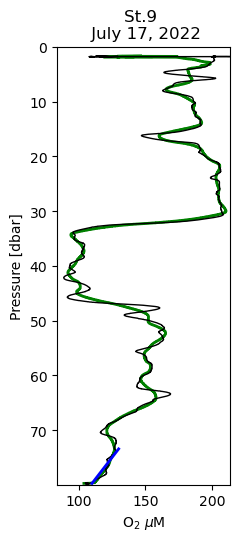

In [11]:
Slope_plot(48,20,.04)

Station:  St.7
Date:  2022-07-12
Slope:  -11.93662272350885
Intercept:  520.977825802257
Pressure:  32.627


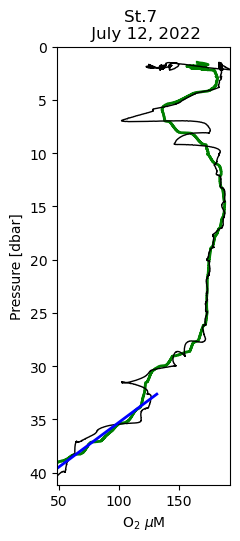

In [12]:
Slope_plot(47,11,.15)

Station:  St.5B
Date:  2022-07-10
Slope:  -25.125008792469934
Intercept:  306.88516832900257
Pressure:  9.744


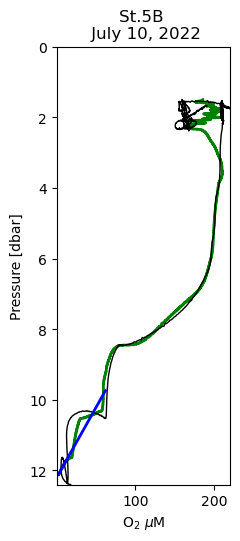

In [13]:
Slope_plot(46,19,.015)

Station:  St.4
Date:  2022-07-10
Slope:  -13.85623465667217
Intercept:  288.3831259609136
Pressure:  16.28


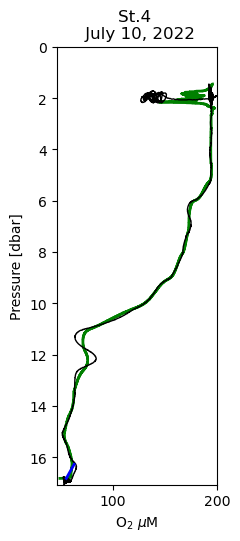

In [14]:
Slope_plot(45,20,.15)

Station:  St.2
Date:  2022-07-19
Slope:  1.4972127913937385
Intercept:  84.35504987829981
Pressure:  51.072


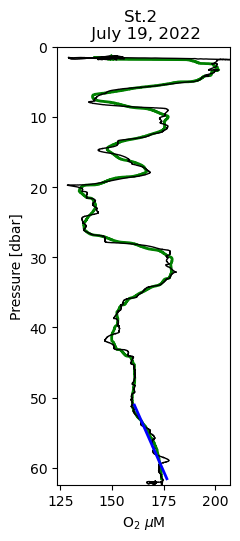

In [15]:
Slope_plot(44,15,.06)

Station:  St.16
Date:  2022-07-20
Slope:  0.4924263937846995
Intercept:  120.86491162074137
Pressure:  53.659


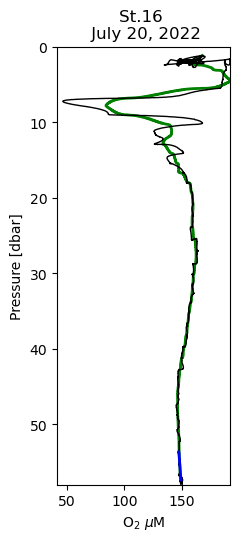

In [16]:
Slope_plot(43,10,.1)

Station:  St.15
Date:  2022-07-15
Slope:  -0.1409405109509922
Intercept:  155.25015285837412
Pressure:  187.953


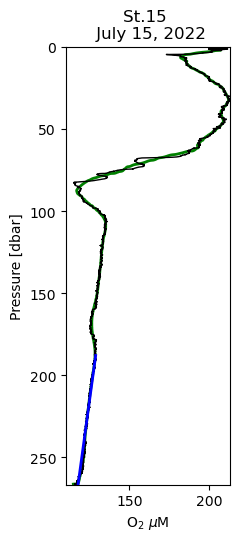

In [17]:
Slope_plot(42,15,.01)

Station:  St.14
Date:  2022-07-16
Slope:  -4.074942504357668
Intercept:  446.1825604189621
Pressure:  67.915


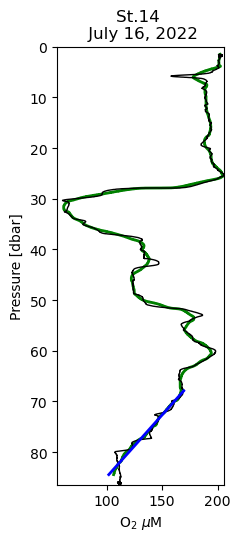

In [18]:
Slope_plot(41,25,.02)

Station:  St.13
Date:  2022-07-18
Slope:  0.03792818607382008
Intercept:  94.29371298362125
Pressure:  445.024


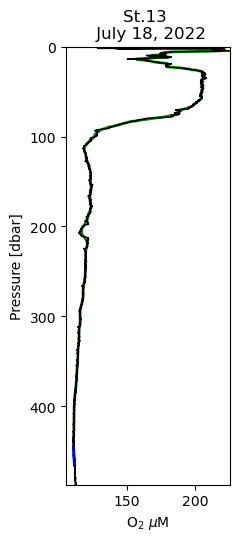

In [19]:
Slope_plot(40,35,.02)

Station:  St.12
Date:  2022-07-21
Slope:  0.1014273515561258
Intercept:  65.00907133646045
Pressure:  418.701


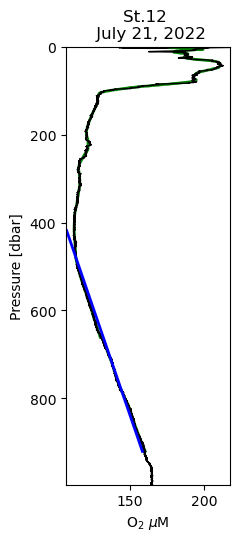

In [20]:
Slope_plot(39,20,.02)

Station:  St.11
Date:  2022-07-22
Slope:  0.10919906621033389
Intercept:  56.80216247457342
Pressure:  478.402


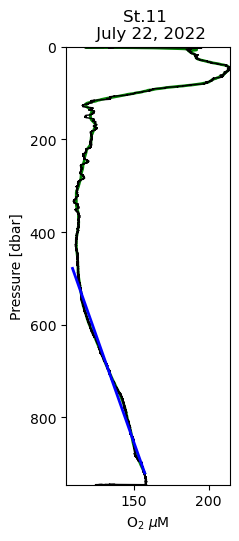

In [21]:
Slope_plot(38,20,.02)

Station:  St.MK
Date:  2022-04-19
Slope:  -25.442151196189528
Intercept:  634.0036340009083
Pressure:  14.583


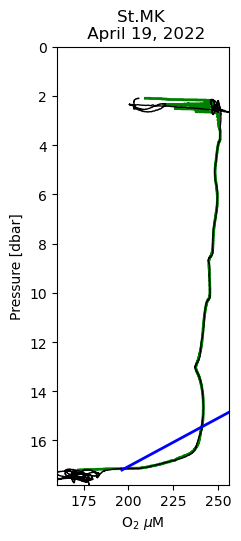

In [22]:
Slope_plot(37,20,.409)

Station:  St.9
Date:  2022-04-16
Slope:  0.23578696314380443
Intercept:  150.1586403428129
Pressure:  72.471


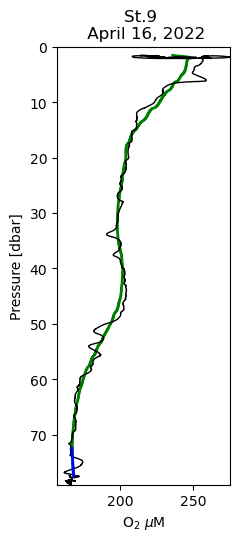

In [23]:
Slope_plot(36,3,.26)

Station:  St.7
Date:  2022-04-10
Slope:  -1.4659915351292852
Intercept:  205.03657008689345
Pressure:  35.486


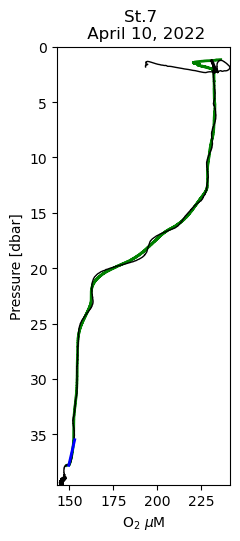

In [24]:
Slope_plot(35,9,.68)

Station:  St.5B
Date:  2022-04-14
Slope:  -74.13797559153507
Intercept:  1144.5069462499732
Pressure:  12.794


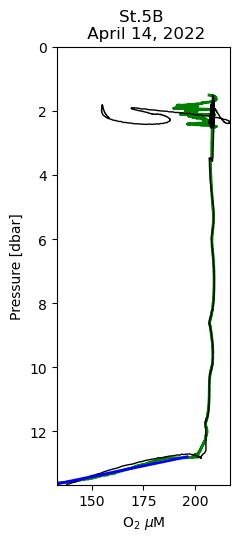

In [25]:
Slope_plot(34,20,.001)

Station:  St.4
Date:  2022-04-20
Slope:  0.3521279856612667
Intercept:  215.0086485051791
Pressure:  14.732


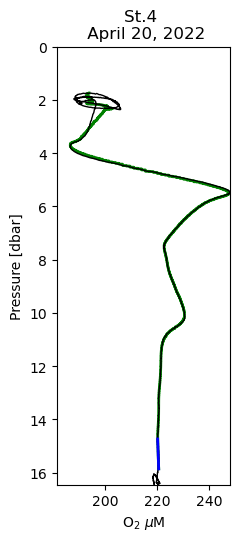

In [26]:
Slope_plot(33,15,.15)

Station:  St.2
Date:  2022-04-17
Slope:  -10.603711529226636
Intercept:  814.9076368346535
Pressure:  59.616


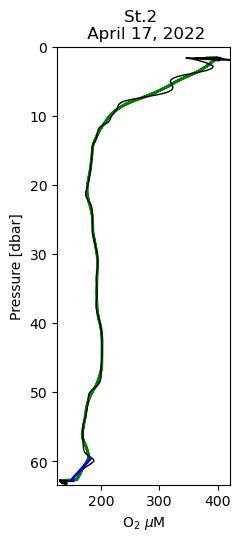

In [27]:
Slope_plot(32,10,.4)

Station:  St.16
Date:  2022-04-11
Slope:  -5.331915754907848
Intercept:  405.754236687676
Pressure:  46.991


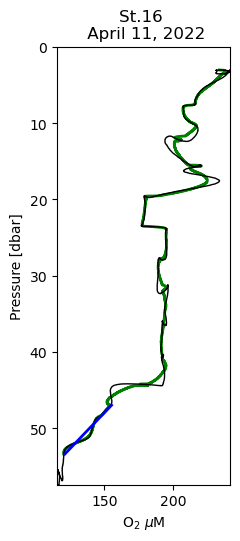

In [28]:
Slope_plot(31,20,.1)

Station:  St.15
Date:  2022-04-16
Slope:  -0.014863170126665498
Intercept:  123.83586287051786
Pressure:  242.723


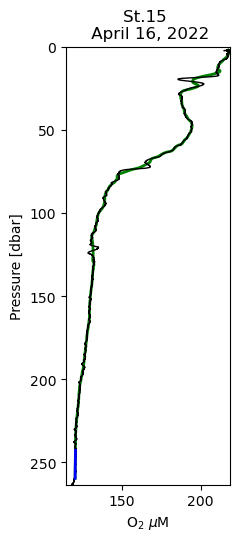

In [29]:
Slope_plot(30,20,.01)

Station:  St.14
Date:  2022-04-09
Slope:  -2.6617159197155265
Intercept:  349.67157867462095
Pressure:  52.79


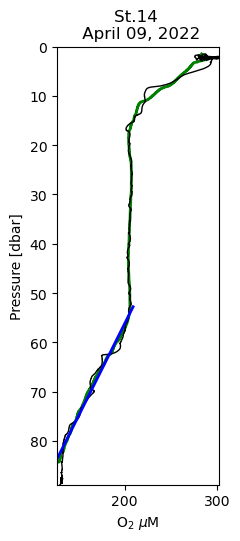

In [30]:
Slope_plot(29,10,.06)

Station:  St.13
Date:  2022-04-18
Slope:  -0.006202971507646246
Intercept:  116.67034056997224
Pressure:  515.633


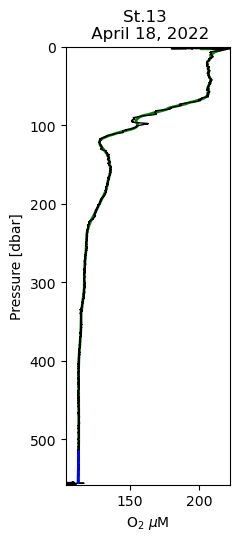

In [31]:
Slope_plot(28,20,.05)

Station:  St.MK
Date:  2021-10-27
Slope:  -22.271716138527008
Intercept:  534.8598388629553
Pressure:  14.324


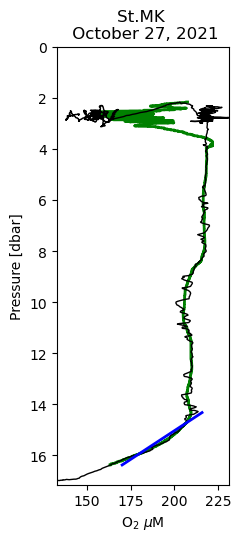

In [32]:
Slope_plot(27,30,.329)

Station:  St.MK-2
Date:  2021-10-30
Slope:  2.4001308266097876
Intercept:  168.79850968482464
Pressure:  13.157


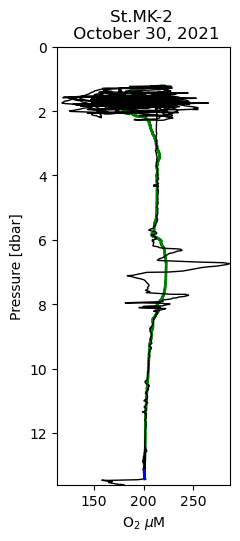

In [33]:
Slope_plot(26,20,.01)

Station:  St.9
Date:  2021-11-01
Slope:  -0.532702307449571
Intercept:  165.64580282401076
Pressure:  75.527


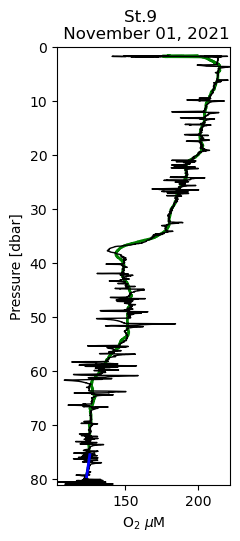

In [34]:
Slope_plot(25,20,.1)

Station:  St.7
Date:  2021-10-31
Slope:  -22.052258715173647
Intercept:  965.8022998843545
Pressure:  36.087


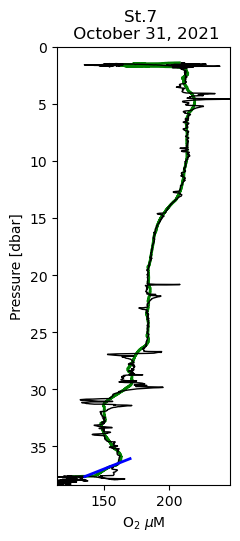

In [35]:
Slope_plot(24,20,.15)

Station:  St.6
Date:  2021-10-25
Slope:  -2.7977198328887707
Intercept:  229.94882879063096
Pressure:  10.867


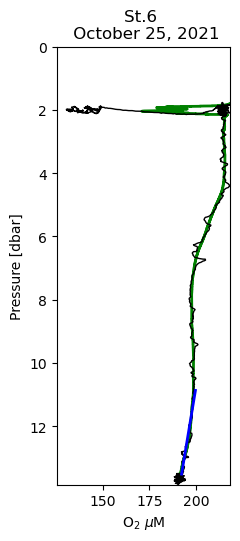

In [36]:
Slope_plot(23,10,.17)

Station:  St.5B
Date:  2021-10-25
Slope:  -3.753916078833229
Intercept:  242.78887480543037
Pressure:  11.969


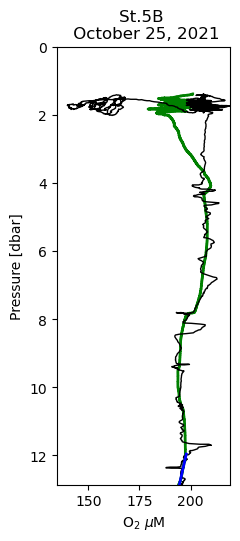

In [37]:
Slope_plot(22,15,.001)

Station:  St.4
Date:  2021-10-26
Slope:  -16.93341356320535
Intercept:  455.1339808605113
Pressure:  14.541


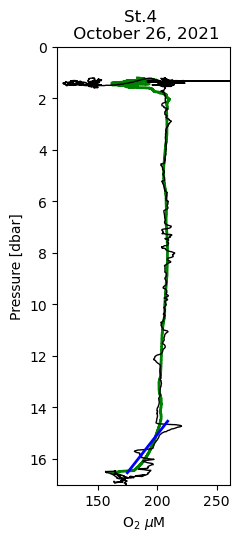

In [38]:
Slope_plot(21,20,.07)

Station:  St.2
Date:  2021-11-02
Slope:  -1.7891147397914593
Intercept:  228.65163236873303
Pressure:  40.184


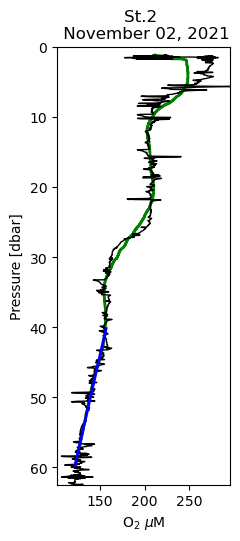

In [39]:
Slope_plot(20,5,.24)

Station:  St.16
Date:  2021-11-08
Slope:  -0.37411548707543046
Intercept:  167.17293430905477
Pressure:  52.168


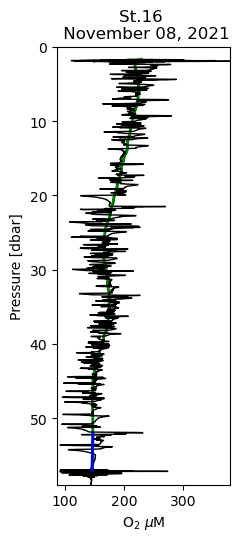

In [40]:
Slope_plot(19,6,.2)

Station:  St.16-2
Date:  2021-11-12
Slope:  -11.81191448204093
Intercept:  315.25023110275026
Pressure:  13.83


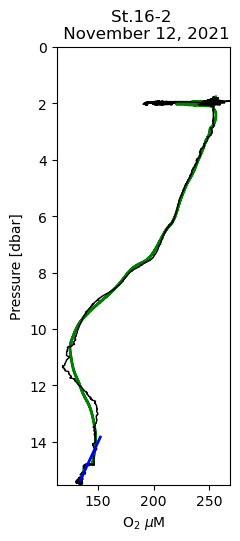

In [41]:
Slope_plot(18,20,.04)

Station:  St.15
Date:  2021-11-02
Slope:  -0.16539128925042743
Intercept:  165.81571059797443
Pressure:  225.613


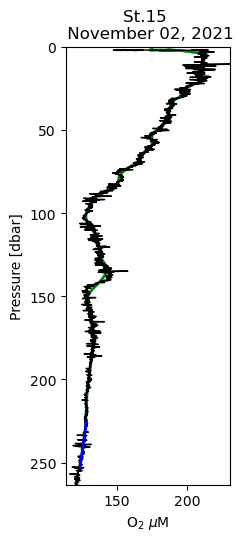

In [42]:
Slope_plot(17,15,.015)

Station:  St.14
Date:  2021-10-31
Slope:  -2.6157945611364624
Intercept:  343.2770415355646
Pressure:  79.529


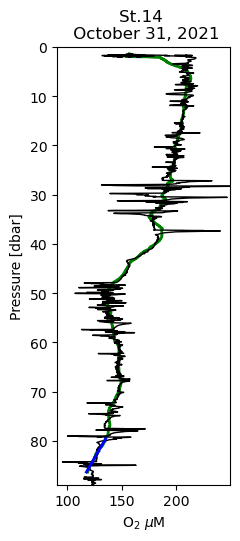

In [43]:
Slope_plot(16,15,.02)

Station:  St.14.5
Date:  2021-11-01
Slope:  -0.7702579552473291
Intercept:  204.7226304591326
Pressure:  92.49


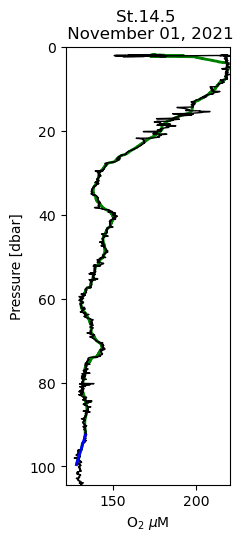

In [44]:
Slope_plot(15,20,.03)

Station:  St.13
Date:  2021-11-07
Slope:  -0.019416466235533555
Intercept:  125.02155306890991
Pressure:  397.762


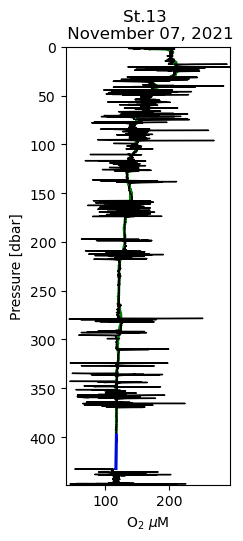

In [45]:
Slope_plot(14,20,.04)

Station:  St.12
Date:  2021-11-09
Slope:  0.12427471836006886
Intercept:  58.17754151172461
Pressure:  491.627


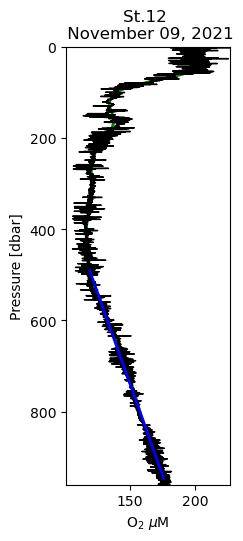

In [46]:
Slope_plot(13,7,.01)

Station:  St.11
Date:  2021-11-10
Slope:  0.11244388516160111
Intercept:  59.28495260954445
Pressure:  512.925


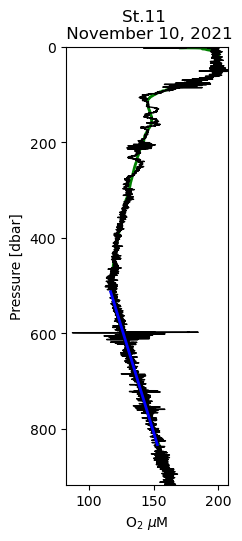

In [47]:
Slope_plot(12,7,.04)

Station:  St.ML
Date:  2021-07-27
Slope:  -8.607122508777845
Intercept:  244.24960339906278
Pressure:  13.267


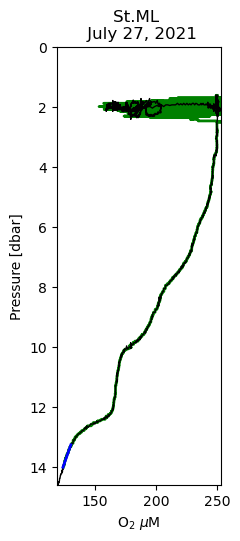

In [48]:
Slope_plot(11,300,.043)

Station:  St.MK
Date:  2021-07-15
Slope:  9.741984027113636
Intercept:  76.82031623433237
Pressure:  11.281


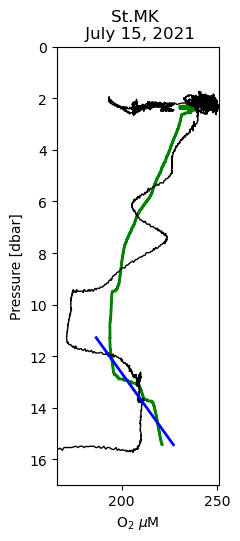

In [49]:
Slope_plot(10,7,.291)

Station:  St.9
Date:  2021-07-20
Slope:  -1.973210446463013
Intercept:  325.3889332850538
Pressure:  69.611


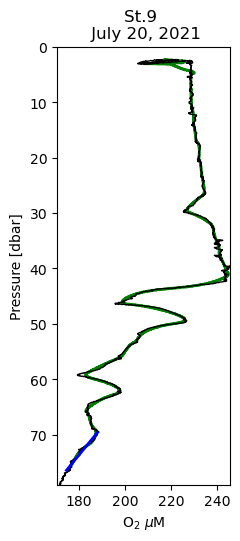

In [50]:
Slope_plot(9,20,.03)

Station:  St.7
Date:  2021-07-26
Slope:  -5.125901676789147
Intercept:  320.2434831321447
Pressure:  31.053


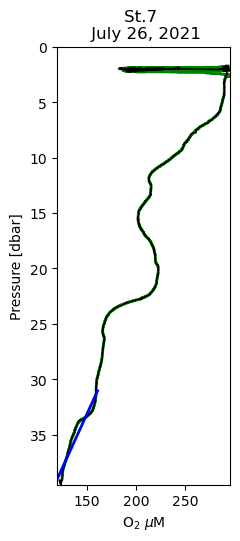

In [51]:
Slope_plot(8,100,.0325)

Station:  St.5B
Date:  2021-07-16
Slope:  2.0280438945945436
Intercept:  220.63031777469004
Pressure:  10.106


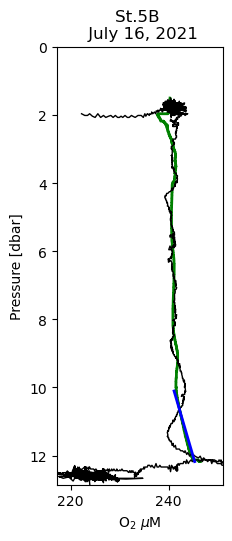

In [52]:
Slope_plot(7,10,.43)

Station:  St.4
Date:  2021-07-17
Slope:  -26.04362822681202
Intercept:  533.2540156220605
Pressure:  11.138


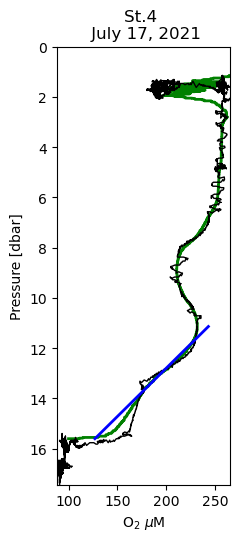

In [53]:
Slope_plot(6,14,.43)

Station:  St.2
Date:  2021-07-22
Slope:  -6.845005242694469
Intercept:  586.8497493893864
Pressure:  56.271


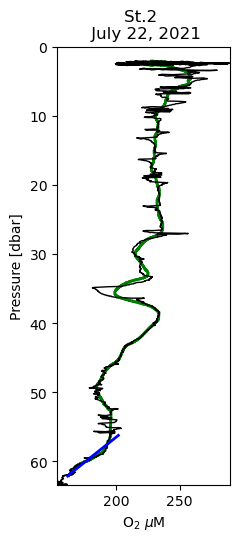

In [54]:
Slope_plot(5,20,.16)

Station:  St.16
Date:  2021-07-24
Slope:  -7.128513599079889
Intercept:  583.6201929880384
Pressure:  49.449


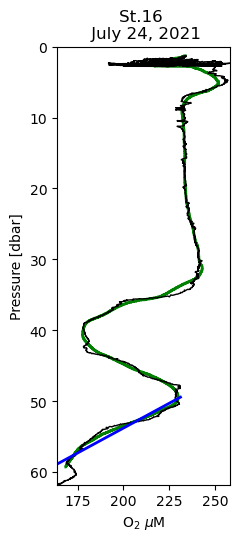

In [55]:
Slope_plot(4,20,.02)

Station:  St.15
Date:  2021-07-23
Slope:  -0.11358815751525325
Intercept:  202.61240048569528
Pressure:  239.206


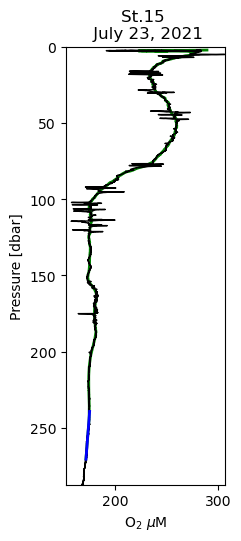

In [56]:
Slope_plot(3,20,.03)

Station:  St.14
Date:  2021-07-19
Slope:  -3.150722644787762
Intercept:  444.4875300762874
Pressure:  65.016


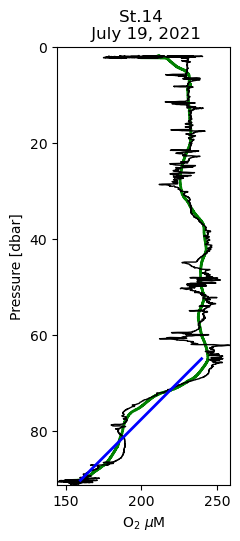

In [57]:
Slope_plot(2,7,.2)

Station:  St.13
Date:  2021-07-21
Slope:  -0.05454546700514339
Intercept:  192.03538972672155
Pressure:  303.323


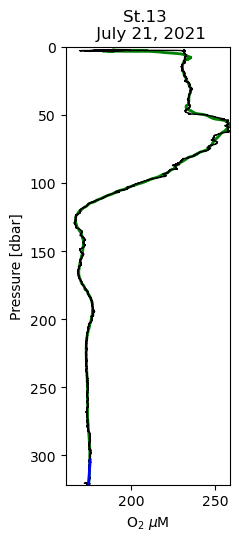

In [58]:
Slope_plot(1,15,.01)

Station:  St.11
Date:  2021-07-25
Slope:  0.16321952619625657
Intercept:  91.15814412971322
Pressure:  568.175


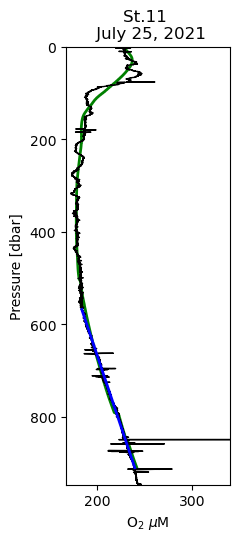

In [59]:
Slope_plot(0,3,.02)

In [60]:
O2_summary['Slope_pressure_percent'] = (O2_summary['Pressure_dbar_bottom']-O2_summary['Slope_pressure'])/O2_summary['Pressure_dbar_bottom']*100
O2_summary

,camp,station,date,Max_pressure,Pressure_dbar_surface,O2_mgL_surface,latitude_surface,longitude_surface,Pressure_dbar_bottom,O2_mgL_bottom,...,temp_surface,temp_bottom,sal_surface,sal_bottom,O2_uM_surface,O2_uM_bottom,code,Slope,Slope_pressure,Slope_pressure_percent
code,,,,,,,,,,,,,,,,,,,,,
St.11_GOM2021,GOM2021,St.11,2021-07-25,946.986,2.076,7.3366,28.21678,-89.54664,946.986,7.8471,...,29.9854,5.1025,36.1896,34.9346,229.275915,245.229538,St.11_GOM2021,0.163220,568.175,40.001753
St.13_GOM2021,GOM2021,St.13,2021-07-21,321.519,2.283,6.2980,28.53696,-89.49614,321.519,5.5889,...,29.8063,11.2036,35.0741,35.3737,196.818651,174.658583,St.13_GOM2021,-0.054545,303.323,5.659386
St.14_GOM2021,GOM2021,St.14,2021-07-19,91.278,1.829,6.3473,28.72514,-89.60390,91.278,4.9078,...,30.2016,19.1043,31.1088,36.4047,198.359324,153.373543,St.14_GOM2021,-3.150723,65.016,28.771445
St.15_GOM2021,GOM2021,St.15,2021-07-23,287.295,2.191,9.0433,28.94254,-88.83508,287.295,5.4067,...,29.4733,11.3417,29.3293,35.3946,282.611957,168.964655,St.15_GOM2021,-0.113588,239.206,16.738544
St.16_GOM2021,GOM2021,St.16,2021-07-24,61.804,1.277,7.4623,28.88042,-89.54684,61.804,5.2200,...,29.8499,20.7100,20.4683,36.3277,233.204163,163.130098,St.16_GOM2021,-7.128514,49.449,19.990615
St.2_GOM2021,GOM2021,St.2,2021-07-22,63.413,2.074,6.8821,28.89964,-89.59322,63.413,4.7733,...,28.9431,20.7587,27.5856,36.3022,215.072346,149.170287,St.2_GOM2021,-6.845005,56.271,11.262675
St.4_GOM2021,GOM2021,St.4,2021-07-17,17.437,1.145,8.2318,28.79886,-90.71040,17.437,2.9017,...,30.3120,27.7279,24.8396,35.3894,257.251789,90.680959,St.4_GOM2021,-26.043628,11.138,36.124333
St.5B_GOM2021,GOM2021,St.5B,2021-07-16,12.856,1.505,7.6929,28.81030,-91.34152,12.856,7.1658,...,29.8254,28.7477,29.1495,33.7462,240.410638,223.938248,St.5B_GOM2021,2.028044,10.106,21.390790
St.7_GOM2021,GOM2021,St.7,2021-07-26,39.529,1.736,9.3420,28.91830,-89.87558,39.529,3.9643,...,30.1656,24.3561,25.4665,36.0396,291.946623,123.888247,St.7_GOM2021,-5.125902,31.053,21.442485


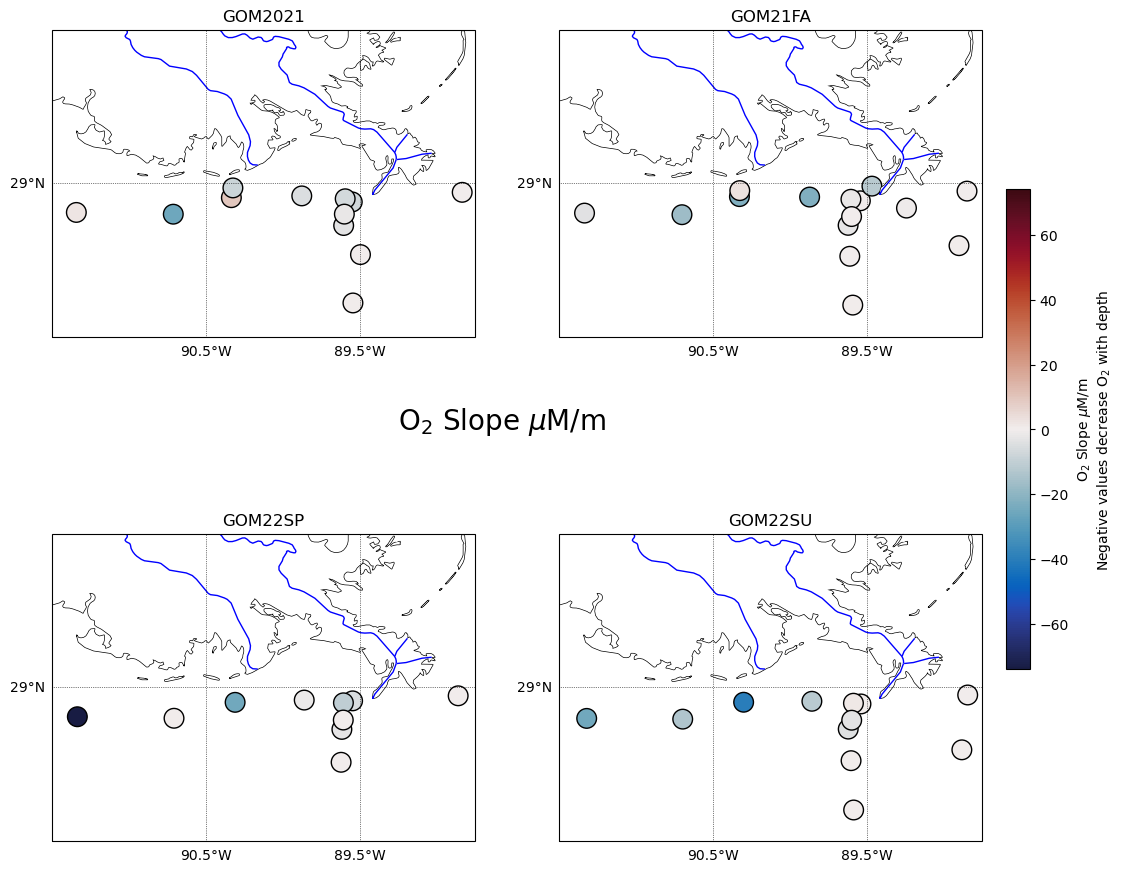

In [61]:
lat_top=30
lat_bot=28
lon_left=-91.5
lon_rigth=-88.75
extent=[lon_left, lon_rigth, lat_bot, lat_top]

# List of unique Camp values you want to plot
camps = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

#set params 
vmin = O2_summary['Slope'].min()
vmax = O2_summary['Slope'].min()*-1
plot_save = "../Dissertation_projects/Figures/CTD_profiles/O2_maps/Slope.png"
cb_name = r'O$_2$ Slope $\mu$M/m'+'\n'+'Negative values decrease '+'O$_2$'+' with depth'

def plot_mapbase(extent, ax=None, res='10m', projection=ccrs.PlateCarree()):
    if ax is None:
        fig = plt.figure(figsize=(10,5)) # set fig size
        ax = fig.add_subplot(111, projection=projection)
        
    ax.set_extent(extent)
    ax.coastlines(res)
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='land',
                                                facecolor='white', 
                                                scale=res)) 
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='rivers_lake_centerlines',
                                                edgecolor='blue',
                                                facecolor='none',
                                                scale=res))
    gl = ax.gridlines(xlocs=np.arange(lon_left, lon_rigth+1),
                      ylocs=np.arange(lat_bot, lat_top+1),
                      draw_labels=True, 
                      linewidth=0.5, color='k', linestyle=':')
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return ax

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.ravel()  # Flatten the 2x2 grid to access each subplot with a single index
for i, camp in enumerate(camps):
    df_subset = O2_summary[O2_summary['camp'] == camp]  
    
    # Plot the base map for each subplot
    plot_mapbase(extent, ax=axes[i])
    
    # Plotting
    mappable = axes[i].scatter(df_subset['longitude_bottom'], df_subset['latitude_bottom'],
                               c=df_subset['Slope'],
                               edgecolor='k',
                               cmap=cmo.balance,
                               s=200,
                               vmin=vmin,  
                               vmax=vmax,
                               transform=ccrs.PlateCarree())
    
    # Set title for each subplot
    axes[i].set_title(camp)
    
# Add a single colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
cb = fig.colorbar(mappable, cax=cbar_ax)
cb.set_label(cb_name, size=10, color='black')
cb.ax.tick_params(labelcolor='black') 
cb.ax.tick_params(labelsize=10)

fig.text(0.5, 0.5, r'O$_2$ Slope $\mu$M/m', size=20, ha='center')

fig.set_facecolor('w')
plt.savefig(plot_save)
plt.show()

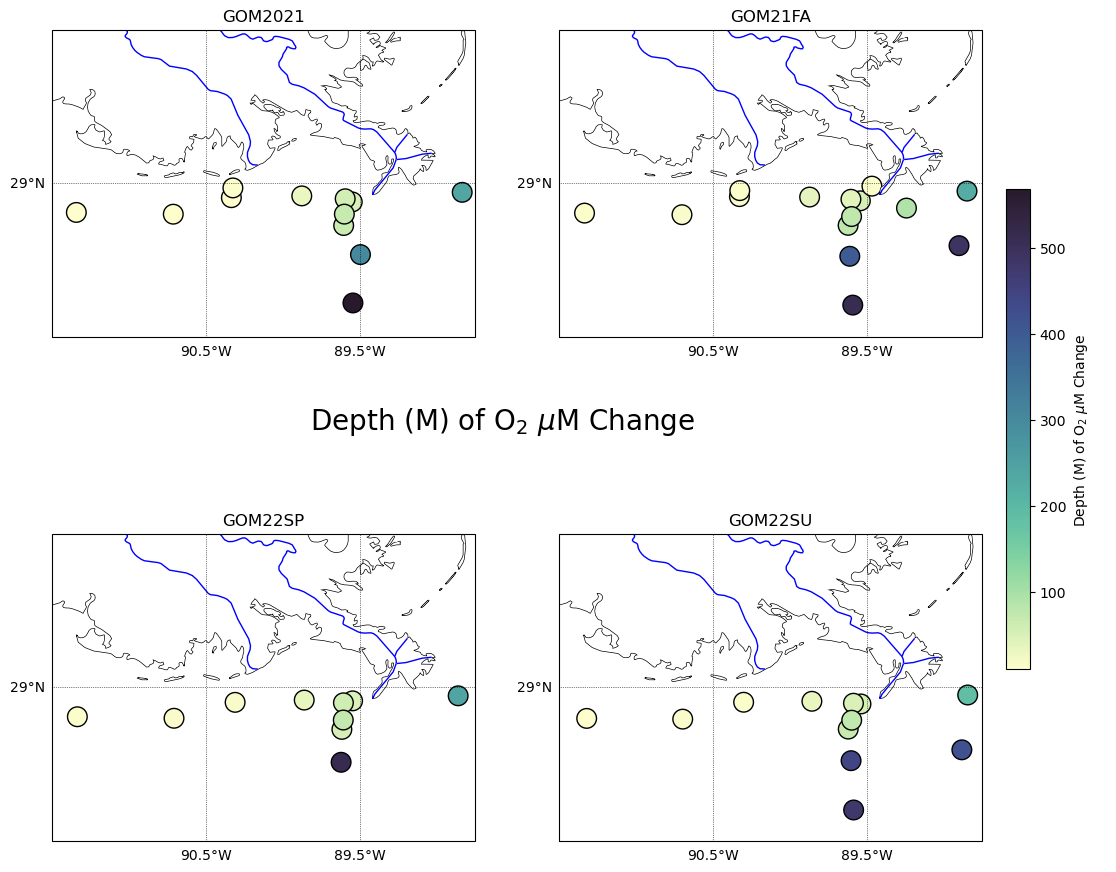

In [62]:
lat_top=30
lat_bot=28
lon_left=-91.5
lon_rigth=-88.75
extent=[lon_left, lon_rigth, lat_bot, lat_top]

# List of unique Camp values you want to plot
camps = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

#set params 
vmin = O2_summary['Slope_pressure'].min()
vmax = O2_summary['Slope_pressure'].max()
plot_save = "../Dissertation_projects/Figures/CTD_profiles/O2_maps/Deep.png"
cb_name = r'Depth (M) of O$_2$ $\mu$M Change'+'\n'

def plot_mapbase(extent, ax=None, res='10m', projection=ccrs.PlateCarree()):
    if ax is None:
        fig = plt.figure(figsize=(10,5)) # set fig size
        ax = fig.add_subplot(111, projection=projection)
        
    ax.set_extent(extent)
    ax.coastlines(res)
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='land',
                                                facecolor='white', 
                                                scale=res)) 
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='rivers_lake_centerlines',
                                                edgecolor='blue',
                                                facecolor='none',
                                                scale=res))
    gl = ax.gridlines(xlocs=np.arange(lon_left, lon_rigth+1),
                      ylocs=np.arange(lat_bot, lat_top+1),
                      draw_labels=True, 
                      linewidth=0.5, color='k', linestyle=':')
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return ax

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.ravel()  # Flatten the 2x2 grid to access each subplot with a single index
for i, camp in enumerate(camps):
    df_subset = O2_summary[O2_summary['camp'] == camp]  
    
    # Plot the base map for each subplot
    plot_mapbase(extent, ax=axes[i])
    
    # Plotting
    mappable = axes[i].scatter(df_subset['longitude_bottom'], df_subset['latitude_bottom'],
                               c=df_subset['Slope_pressure'],
                               edgecolor='k',
                               cmap=cmo.deep,
                               s=200,
                               vmin=vmin,  
                               vmax=vmax,
                               transform=ccrs.PlateCarree())
    
    # Set title for each subplot
    axes[i].set_title(camp)
    
# Add a single colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
cb = fig.colorbar(mappable, cax=cbar_ax)
cb.set_label(cb_name, size=10, color='black')
cb.ax.tick_params(labelcolor='black') 
cb.ax.tick_params(labelsize=10)

fig.text(0.5, 0.5, r'Depth (M) of O$_2$ $\mu$M Change', size=20, ha='center')

fig.set_facecolor('w')
plt.savefig(plot_save)
plt.show()

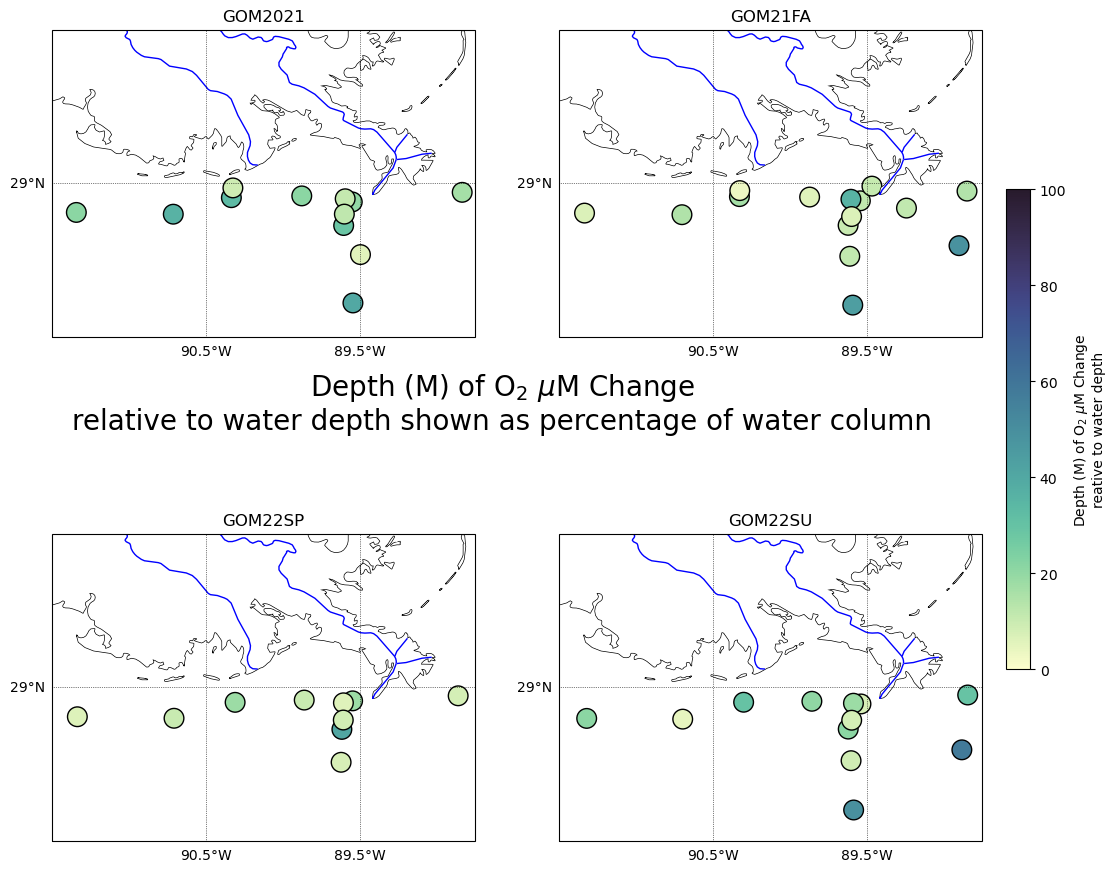

In [63]:
lat_top=30
lat_bot=28
lon_left=-91.5
lon_rigth=-88.75
extent=[lon_left, lon_rigth, lat_bot, lat_top]

# List of unique Camp values you want to plot
camps = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

#set params 
vmin = 0
vmax = 100
plot_save = "../Dissertation_projects/Figures/CTD_profiles/O2_maps/Deep.png"
cb_name = r'Depth (M) of O$_2$ $\mu$M Change'+'\n'+'reative to water depth'

def plot_mapbase(extent, ax=None, res='10m', projection=ccrs.PlateCarree()):
    if ax is None:
        fig = plt.figure(figsize=(10,5)) # set fig size
        ax = fig.add_subplot(111, projection=projection)
        
    ax.set_extent(extent)
    ax.coastlines(res)
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='land',
                                                facecolor='white', 
                                                scale=res)) 
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='rivers_lake_centerlines',
                                                edgecolor='blue',
                                                facecolor='none',
                                                scale=res))
    gl = ax.gridlines(xlocs=np.arange(lon_left, lon_rigth+1),
                      ylocs=np.arange(lat_bot, lat_top+1),
                      draw_labels=True, 
                      linewidth=0.5, color='k', linestyle=':')
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return ax

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.ravel()  # Flatten the 2x2 grid to access each subplot with a single index
for i, camp in enumerate(camps):
    df_subset = O2_summary[O2_summary['camp'] == camp]  
    
    # Plot the base map for each subplot
    plot_mapbase(extent, ax=axes[i])
    
    # Plotting
    mappable = axes[i].scatter(df_subset['longitude_bottom'], df_subset['latitude_bottom'],
                               c=df_subset['Slope_pressure_percent'],
                               edgecolor='k',
                               cmap=cmo.deep,
                               s=200,
                               vmin=vmin,  
                               vmax=vmax,
                               transform=ccrs.PlateCarree())
    
    # Set title for each subplot
    axes[i].set_title(camp)
    
# Add a single colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
cb = fig.colorbar(mappable, cax=cbar_ax)
cb.set_label(cb_name, size=10, color='black')
cb.ax.tick_params(labelcolor='black') 
cb.ax.tick_params(labelsize=10)

fig.text(0.5, 0.5, r'Depth (M) of O$_2$ $\mu$M Change'+'\n'+'relative to water depth shown as percentage of water column', size=20, ha='center')

fig.set_facecolor('w')
plt.savefig(plot_save)
plt.show()

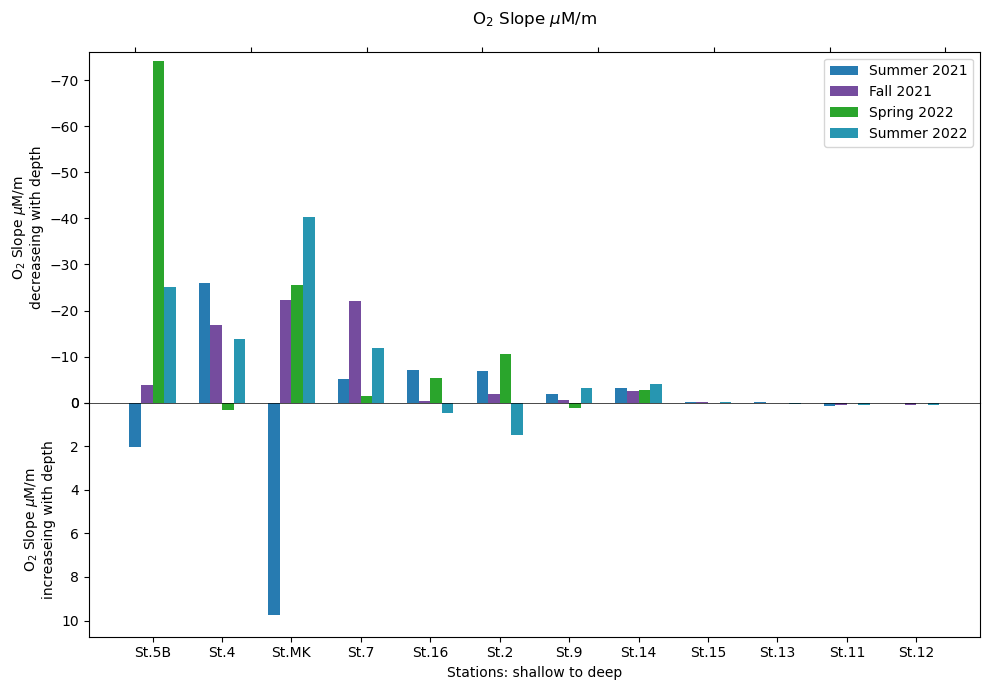

In [64]:
# Unique categories and subcategories
categories = ['St.5B','St.4','St.MK','St.7','St.16','St.2','St.9','St.14','St.15','St.13','St.11','St.12']
subcategories = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

topic = "Slope"
plot_save = "../Dissertation_projects/Figures/CTD_profiles/O2_maps/Bar_slope.png"
title = r'O$_2$ Slope $\mu$M/m'+'\n'

barWidth = 0.25

# Create figure with custom size
fig = plt.figure(figsize=(10, 7))
# Adjust the height ratios for the subplots
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 2], hspace=0)  # Set hspace to 0

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

# Adjusted r for spacing between groups
r = np.arange(0, len(categories) * 1.5, 1.5)
positions = [r + i*barWidth for i in range(len(subcategories))]

# Adjusted code for broken axis and added spaces between the groups
for pos, subcat in zip(positions, subcategories):
    values = []
    errors = []
    for cat in categories:
        value = O2_summary[(O2_summary['station'] == cat) & (O2_summary['camp'] == subcat)]['Slope'].values
        #error = df[(df['Stn'] == cat) & (df['Camp'] == subcat)]['erros_doc'].values
        values.append(value[0] if len(value) > 0 else 0)
        #errors.append(error[0] if len(error) > 0 else 0)
    
    ax2.bar(pos, [v if v > 0 else 0 for v in values], width=barWidth, color=color_map[subcat],
            label=label_map[subcat])#, yerr=[e if e > 0 else 0 for e in errors])
    ax1.bar(pos, [v if v < 0 else 0 for v in values], width=barWidth, color=color_map[subcat],
            label=label_map[subcat])#, yerr=[e if e > 0 else 0 for e in errors])
    
# Setting the limit for the break
ax2.set_ylim(O2_summary['Slope'].max()+1,0)  
ax1.set_ylim(0,O2_summary['Slope'].min()-2)

# Removing spines and ticks for the broken axis effect
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off')
ax2.xaxis.tick_bottom()

# Add some text for labels, title, and custom x-axis tick labels
ax2.set_xlabel('Stations: shallow to deep')
ax2.set_ylabel(r'O$_2$ Slope $\mu$M/m'+'\n'+'increaseing with depth')
ax1.set_ylabel(r'O$_2$ Slope $\mu$M/m'+'\n'+'decreaseing with depth')
ax1.set_title(title)
ax2.set_xticks(r + 1.5*barWidth)  # Adjust for the spaces between groups
ax2.set_xticklabels(categories)
ax1.set_xticklabels('')


# Add black horizontal line at y=0
ax1.axhline(0, color="black", linewidth=0.5)
ax2.axhline(0, color="black", linewidth=0.5)

handles, _ = plt.gca().get_legend_handles_labels()
labels = [label_map[subcat] for subcat in subcategories]
ax1.legend(handles[:len(subcategories)], labels)

fig.set_facecolor('w')
plt.tight_layout()

plt.savefig(plot_save)
plt.show()

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_15280\2263122225.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(categories)


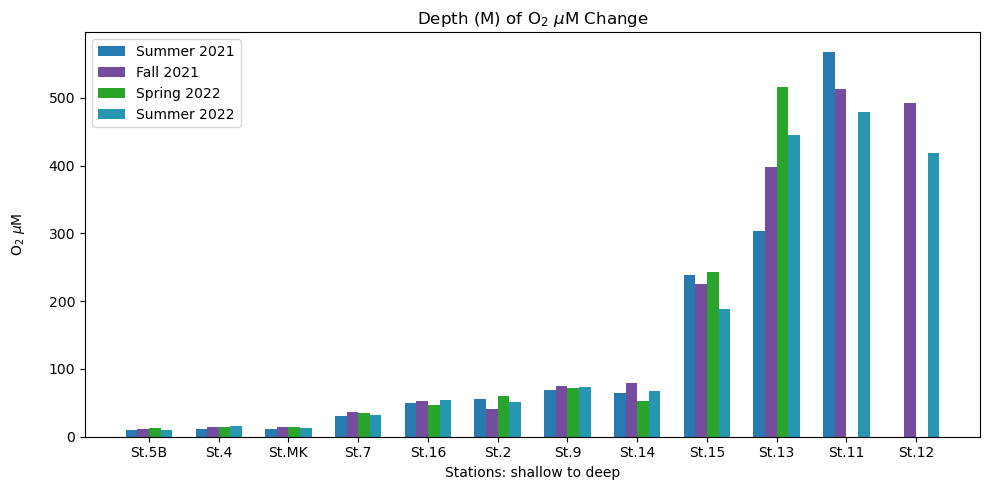

In [65]:
topic = "Slope_pressure"
plot_save = "../Dissertation_projects/Figures/CTD_profiles/O2_maps/Bar_O2_depth.png"
title = r'Depth (M) of O$_2$ $\mu$M Change'

bar_plot(O2_summary)

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_15280\2263122225.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(categories)


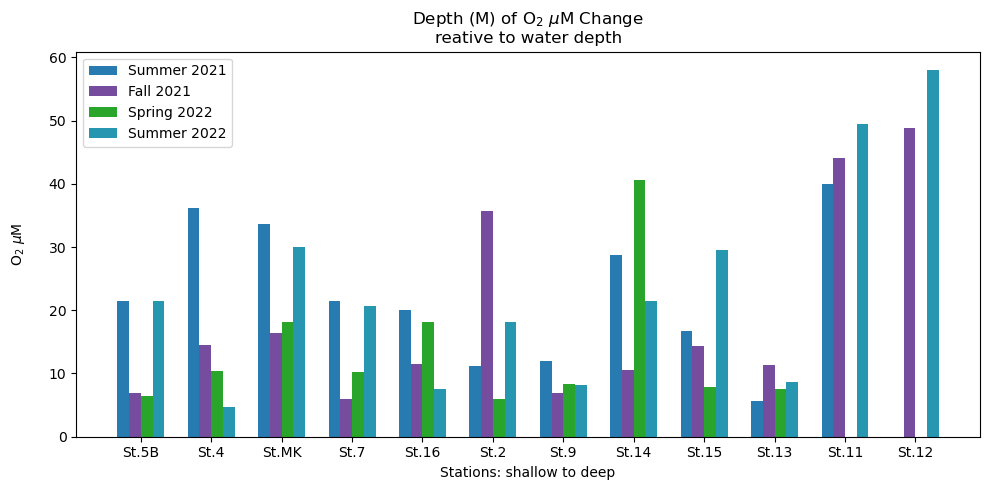

In [66]:
topic = "Slope_pressure_percent"
plot_save = "../Dissertation_projects/Figures/CTD_profiles/O2_maps/Bar_O2_depth_percent.png"
title = r'Depth (M) of O$_2$ $\mu$M Change'+'\n'+'reative to water depth'

bar_plot(O2_summary)

In [67]:
O2_summary.to_csv('../Dissertation_projects/Data/CTD/O2_Summary_Stats.csv')

In [68]:
O2_summary.to_csv('../Dissertation_projects/Data/Stats_data_sets/O2_Summary_Stats.csv')

In [69]:
O2_summary['temp_surface']

code
St.11_GOM2021      29.9854
St.13_GOM2021      29.8063
St.14_GOM2021      30.2016
St.15_GOM2021      29.4733
St.16_GOM2021      29.8499
St.2_GOM2021       28.9431
St.4_GOM2021       30.3120
St.5B_GOM2021      29.8254
St.7_GOM2021       30.1656
St.9_GOM2021       28.8984
St.MK_GOM2021      30.0306
St.ML_GOM2021      31.1137
St.11_GOM21FA      26.5521
St.12_GOM21FA      26.0428
St.13_GOM21FA      23.1445
St.14_GOM21FA      23.4554
St.14.5_GOM21FA    24.5038
St.15_GOM21FA      24.0363
St.16_GOM21FA      20.2444
St.16-2_GOM21FA    21.1505
St.2_GOM21FA       22.3774
St.4_GOM21FA       26.3893
St.5B_GOM21FA      26.5489
St.6_GOM21FA       26.6966
St.7_GOM21FA       24.9819
St.9_GOM21FA       23.5342
St.MK_GOM21FA      26.3911
St.MK-2_GOM21FA    22.9606
St.13_GOM22SP      24.2364
St.14_GOM22SP      20.6425
St.15_GOM22SP      22.2960
St.16_GOM22SP      21.0723
St.2_GOM22SP       23.4872
St.4_GOM22SP       22.7397
St.5B_GOM22SP      21.9150
St.7_GOM22SP       20.6164
St.9_GOM22SP       22.8